# Network embedding

Generally speaking, an **embedding** refers to some technique which takes a network (or
networks as we'll see later) and converts it to a representation in some vector space.
Often, this is a Euclidean vector space, and in that space each vector represents a
single node in the network. We'll focus on this case for now.

## Why embed networks? 
- Embedding networks can be viewed as fitting the parameters of statistical models, 
  for example, a random dot product graph.
- Embeddings can be useful for creating visualizations of networks. 
- Embeddings allow us to use a wide range of general machine learning techniques and
  make them applicable for networks.

## Spectral methods

## DeepWalk / Node2Vec

### Word2vec

To start understanding DeepWalk and Node2Vec, it's most helpful to take a brief detour
and look at Word2Vec {cite}`mikolov2013efficient`. If you are curious about Word2Vec,
you can find a fairly accessible introduction at [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

**Word2Vec** is an unsupervised language model developed by researchers at Google. The first
key idea, which is very common in natural language processing (NLP), is that we can
train a model (in this case a neural network) on a "fake" supervised learning task. In
other words, we take a huge dataset without labels (e.g. all of the text you can find
on the internet, say) and make a labeled dataset from it. This is done by moving a
sliding window over each sentence, and creating (_center word_, _surrounding word_) 
pairs. The task, then, is to predict the surrounding words from the word in the center.
In this way, we are training a model to understand the *context* of the center word
as it is used in language.

```{figure} ./images/w2v-training-data.png
Diagram showing how source text is converted to training data for the Word2Vec / Skip-gram
model. Figure from [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).
```

What does this model actually look like? In the case of Word2Vec, it is simply a 2-layer
neural network. We wont talk much about the details of neural networks for the purposes
of this course, but the key idea is that neural networks are functions which we train
(via sets of labeled data) to predict some output based on some input. Neural networks
do so by taking input that can be represented mathematically somehow (e.g. as a vector), 
and more or less performing a series of matrix-vector multiplications followed by some nonlinearities to reach an output which usually represents the probability of some 
particular output.

```{figure} ./images/word2vec-skip-gram.png
Diagram showing the architecture of Word2Vec. Figure from [here](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html).
```

Note that the first part of this neural network architecture is just a weight, which 
maps each word in our vocabulary to some hidden representation which is useful for 
predicting the context of a word. After training, this weight matrix is used as the 
*embedding* for each word in our vocabulary.

### From Word2Vec to DeepWalk

Given the success of Word2Vec (as of 2022 I saw it had >24,000 citations), it made sense
to wonder whether this fairly simple tool could be applied to other contexts, like 
networks. 

```{admonition}
:class: tip 
Word2Vec eats _sentences_ which are composed of _tokens_ for training. For a network,
how could we generate a sequence of tokens? What would the tokens represent?
```

One "sequence on a network" that keeps coming up for us is random walks (see [](centrality.ipynb)). So, what if we generate a ton of random walks on our network, and then trained a 
Word2Vec model to predict context nodes from the nodes in the center of a window.

```{figure} ./images/deepwalk.png
Overview of DeepWalk. Figure from {cite:t}`perozzi2014deepwalk`
```

### From DeepWalk to Node2Vec

Node2Vec further modified the algorithm from DeepWalk, mainly by modifying the way that
random walks are generated. Rather than being true random walks, these paths through
the network are biased to be more or less likely to travel in the neighborhood they came
from based on some user provided parameters. The authors claimed that adjusting these
parameters based on the application let them find more useful representations for
some datasets, but this result has been debated somewhat.

```{figure} ./images/n2v-modification.png
Modification to random walks from Node2Vec. Figure from {cite:t}`grover2016node2vec`
```

### Running Node2Vec

We can learn a Node2Vec embedding easily using `graspologic` - note that many other
implementations are available. Under the hood, this one uses `gensim` to create a 
Word2Vec model.

In [83]:
import networkx as nx

g = nx.read_edgelist(
    "networks-course/data/cora/edges.csv", delimiter=",", create_using=nx.DiGraph
)

len(g)  # number of nodes

23166

In [84]:
from graspologic.embed import node2vec_embed

node2vec_embedding, node_labels = node2vec_embed(
    g, num_walks=10, walk_length=16, inout_hyperparameter=1.0, return_hyperparameter=1.0
)

/Users/bpedigo/JHU_code/bilateral/graspologic/graspologic/utils/utils.py:1130: UserWarning: Graph has at least one unweighted edge using weight_attribute "weight". Defaulting unweighted edges to "1.0"
  warnings.warn(


In [85]:
node2vec_embedding.shape

(23166, 128)

So, we now have a 128-dimensional vector associated with each node in our network. It
can be useful to use UMAP {cite}`mcinnes2018umap` or other dimensionality reduction 
techniques to further compress these vectors into a 2D plot.

In [86]:
from umap import UMAP

umapper = UMAP(metric="cosine")
umap_node2vec_embedding = umapper.fit_transform(node2vec_embedding)

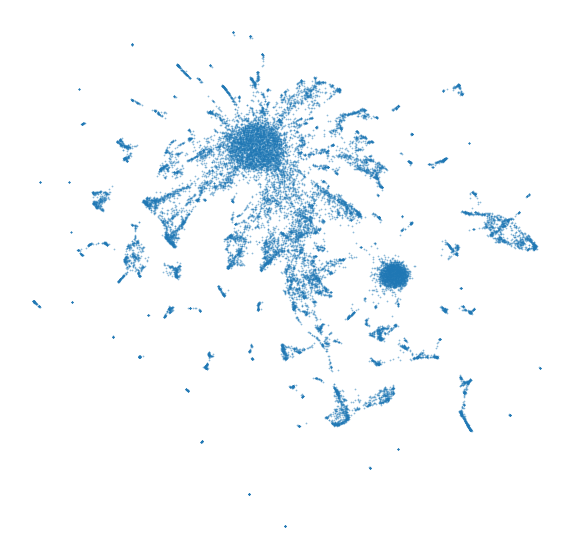

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=umap_node2vec_embedding[:, 0],
    y=umap_node2vec_embedding[:, 1],
    ax=ax,
    s=3,
    alpha=0.5,
    linewidth=0,
)
_ = ax.axis("off")

Now let's try using the Cora dataset, which is a network of academic citations.

In [89]:
edge_df = pd.read_csv("./networks-course/data/cora_nr/cora.edges")
g = nx.from_pandas_edgelist(edge_df, create_using=nx.Graph, edge_attr=None)
print(len(g.nodes))
print(len(g.edges))

2708
5278


In [90]:
node2vec_embedding, node_ids = node2vec_embed(
    g,
    dimensions=16,
    num_walks=10,
    walk_length=16,
    inout_hyperparameter=1.0,
    return_hyperparameter=1.0,
)

/Users/bpedigo/JHU_code/bilateral/graspologic/graspologic/utils/utils.py:1130: UserWarning: Graph has at least one unweighted edge using weight_attribute "weight". Defaulting unweighted edges to "1.0"
  warnings.warn(


In [91]:
node_ids[:10]

[1, 9, 436, 545, 4, 198, 464, 602, 5, 171]

In [92]:
import pandas as pd

nodes = pd.read_csv("networks-course/data/cora_nr/cora.node_labels", index_col=0)
nodes

,label
node_id,
1,3
2,6
3,5
4,5
5,4
...,...
2704,2
2705,2
2706,2


In [93]:
umapper = UMAP(metric="cosine", min_dist=0.8)
umap_node2vec_embedding = umapper.fit_transform(node2vec_embedding)

In [94]:
nodes = nodes.reindex(node_ids)
nodes["umap_0"] = umap_node2vec_embedding[:, 0]
nodes["umap_1"] = umap_node2vec_embedding[:, 1]
nodes["label"] = nodes["label"].astype(str)  # for seaborn

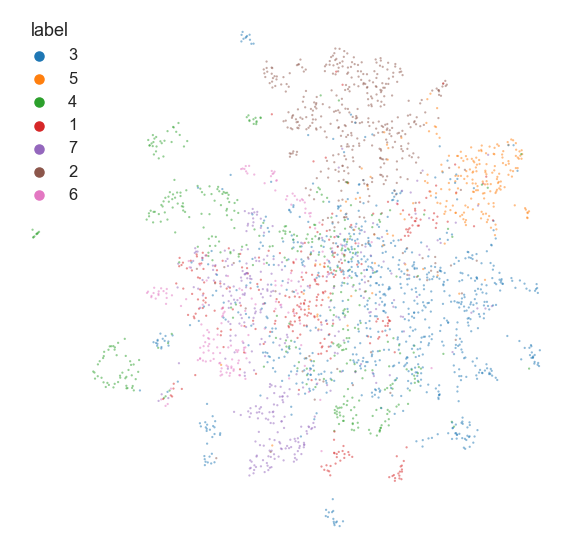

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_context("talk")
sns.scatterplot(
    data=nodes,
    x="umap_0",
    y="umap_1",
    ax=ax,
    hue="label",
    s=5,
    alpha=0.5,
    linewidth=0,
)
_ = ax.axis("off")

You can also use this representation to make a network layout at the same time, which
is something we often do.

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

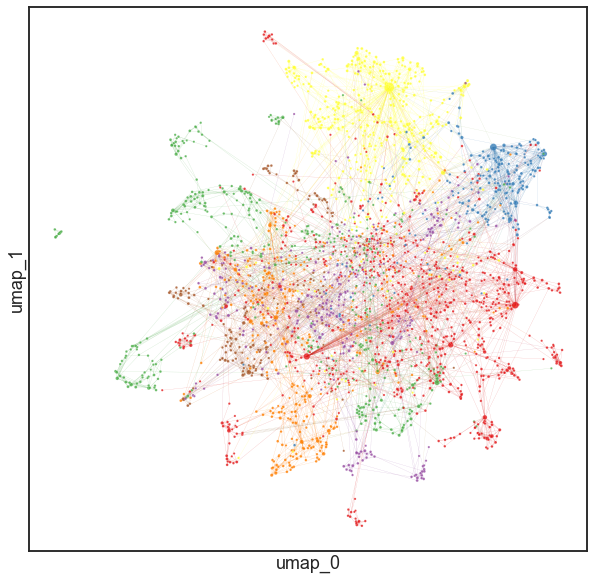

In [102]:
adj = nx.to_scipy_sparse_matrix(g, nodelist=node_ids)

from graspologic.plot import networkplot
import numpy as np 

nodes["degree"] = np.array(np.sum(adj, axis=1))

networkplot(
    adj,
    x="umap_0",
    y="umap_1",
    node_data=nodes.reset_index(),
    node_hue="label",
    node_size="degree",
    node_sizes=(5, 100),
)

## Applications using embeddings

### Recommendation

### Clustering

## Considerations for embeddings

### Dimensions selection
- No great answer
- Depends on application

### More than one "truth"
- Two truths paper
- Possibly anecdote from MSR

### Orthogonal invariance

### Regularizations
- Degree, etc.

## References 
```{bibliography}
:filter: docname in docnames
:style: unsrt
```